# 🧬 Battery Capacity Prediction - TPOT Genetic Programming Analysis

## 🎯 TPOT Overview
**TPOT (Tree-based Pipeline Optimization Tool)** uses genetic programming to automatically discover optimal machine learning pipelines. It evolves:
- **Feature preprocessing** (scaling, selection, engineering)
- **Model selection** (regression algorithms)
- **Hyperparameter optimization**
- **Complete pipeline architecture**

## 📋 Methodology Overview
- **Training Set (80%)**: Used for TPOT evolution and cross-validation
- **Test Set (20%)**: Completely unseen data for final evaluation
- **Genetic Programming**: Population evolution over multiple generations
- **Cross-Validation**: 5-fold CV during pipeline evaluation

## 🧬 Genetic Programming Process
1. **Initial Population**: Random pipelines with different algorithms and preprocessing
2. **Evolution**: Crossover, mutation, and selection over generations
3. **Fitness Evaluation**: Cross-validation performance on training data
4. **Best Pipeline**: Optimal pipeline discovered through evolution

## ✅ Analysis Goals
1. Discover optimal ML pipelines through genetic programming
2. Compare evolved pipelines vs individual models
3. Evaluate feature engineering and preprocessing impact
4. Detect overfitting through rigorous train/test evaluation
5. Export production-ready optimized pipeline


In [10]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import time
from datetime import datetime
warnings.filterwarnings('ignore')

# TPOT and sklearn imports
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Custom modules
from src.data_loader import DataLoader

print("🧬 TPOT Genetic Programming Analysis")
print("=" * 50)
print("✅ All libraries imported successfully!")
print("🚀 Ready for automated pipeline discovery")


🧬 TPOT Genetic Programming Analysis
✅ All libraries imported successfully!
🚀 Ready for automated pipeline discovery


In [18]:
# Load and prepare data
print("📁 Loading battery capacity dataset...")

current_dir = Path.cwd()
data_path = current_dir / "dataset_299.xlsx"
results_dir = current_dir / "results"
tpot_dir = results_dir / "tpot_results"
tpot_dir.mkdir(parents=True, exist_ok=True)

# Load data using custom data loader
data_loader = DataLoader(data_path)
df = data_loader.load_data()
X, y = data_loader.split_features_target(df)

print(f"📊 Dataset shape: {df.shape}")
print(f"🔢 Features: {X.shape[1]}")
print(f"🎯 Target: {y.shape[0]} samples")
print(f"📈 Target statistics:")
print(y.describe().round(4))

# Display feature information
print(f"\n🧮 Feature Overview:")
print(f"   • Temperature features: {sum(1 for col in X.columns if 'Temp' in col)}")
print(f"   • Frequency features: {sum(1 for col in X.columns if 'Hz' in col)}")
print(f"   • Real/Imaginary pairs: {sum(1 for col in X.columns if any(x in col for x in ['RE', 'IM']))}")

print("\n✅ Data loaded and prepared successfully!")


📁 Loading battery capacity dataset...
Successfully loaded data with shape: (299, 62)
Index(['Cell ID', 'Average Capacity'], dtype='object')
📊 Dataset shape: (299, 62)
🔢 Features: 60
🎯 Target: 299 samples
📈 Target statistics:
count     299.0000
mean     7758.9942
std       624.9479
min      4106.4770
25%      7617.6000
50%      7879.6720
75%      8123.5050
max      8579.0650
Name: Average Capacity, dtype: float64

🧮 Feature Overview:
   • Temperature features: 0
   • Frequency features: 60
   • Real/Imaginary pairs: 60

✅ Data loaded and prepared successfully!


In [20]:
# Prepare train/test split (same methodology as PyCaret analysis)
print("🔄 Preparing train/test split...")
print("📊 Using same methodology as PyCaret for fair comparison")

# Split data: 80% train, 20% test (unseen)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=123,  # Same seed as PyCaret analysis
    shuffle=True
)

print(f"✅ Data split completed:")
print(f"   📚 Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   🔒 Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   🎯 Features: {X_train.shape[1]}")

# Basic data quality check
print(f"\n🔍 Data Quality Check:")
print(f"   • Missing values in train: {X_train.isnull().sum().sum()}")
print(f"   • Missing values in test: {X_test.isnull().sum().sum()}")
print(f"   • Feature range: [{X_train.min().min():.6f}, {X_train.max().max():.6f}]")
print(f"   • Target range: [{y_train.min():.4f}, {y_train.max():.4f}]")

print("\n🔒 Test set is now completely isolated and unseen!")
print("🧬 TPOT will only see training data during evolution")


🔄 Preparing train/test split...
📊 Using same methodology as PyCaret for fair comparison
✅ Data split completed:
   📚 Training set: 239 samples (79.9%)
   🔒 Test set: 60 samples (20.1%)
   🎯 Features: 60

🔍 Data Quality Check:
   • Missing values in train: 0
   • Missing values in test: 0
   • Feature range: [-0.000980, 0.009826]
   • Target range: [4106.4770, 8579.0650]

🔒 Test set is now completely isolated and unseen!
🧬 TPOT will only see training data during evolution


In [21]:
# Configure TPOT for comprehensive analysis
print("⚙️ Configuring TPOT Genetic Programming...")

# TPOT Configuration for thorough analysis
tpot_config = {
    'generations': 20,           # Number of evolutionary generations
    'population_size': 50,       # Size of population in each generation  
    'cv': 5,                    # 5-fold cross-validation (same as PyCaret)
    'scoring': 'neg_mean_squared_error',  # Optimization metric
    'verbosity': 2,             # Detailed progress output
    'random_state': 123,        # Reproducibility
    'n_jobs': -1,              # Use all CPU cores
    'max_time_mins': 60,       # Maximum runtime: 1 hour
    'max_eval_time_mins': 5,   # Max time per pipeline evaluation
    'config_dict': 'TPOT light'  # Use lighter config for faster execution
}

print(f"🧬 TPOT Configuration:")
print(f"   • Generations: {tpot_config['generations']}")
print(f"   • Population size: {tpot_config['population_size']}")
print(f"   • Total evaluations: ~{tpot_config['generations'] * tpot_config['population_size']}")
print(f"   • Cross-validation: {tpot_config['cv']}-fold")
print(f"   • Max runtime: {tpot_config['max_time_mins']} minutes")
print(f"   • Scoring: {tpot_config['scoring']}")

print(f"\n🎯 Expected Analysis:")
print(f"   • TPOT will test various preprocessing techniques")
print(f"   • Multiple regression algorithms will be evaluated")
print(f"   • Feature engineering combinations will be explored")
print(f"   • Hyperparameters will be optimized automatically")
print(f"   • Best pipeline will emerge through evolution")

print(f"\n⏱️ Estimated runtime: {tpot_config['max_time_mins']} minutes maximum")
print("🚀 Ready to start genetic programming evolution!")


⚙️ Configuring TPOT Genetic Programming...
🧬 TPOT Configuration:
   • Generations: 20
   • Population size: 50
   • Total evaluations: ~1000
   • Cross-validation: 5-fold
   • Max runtime: 60 minutes
   • Scoring: neg_mean_squared_error

🎯 Expected Analysis:
   • TPOT will test various preprocessing techniques
   • Multiple regression algorithms will be evaluated
   • Feature engineering combinations will be explored
   • Hyperparameters will be optimized automatically
   • Best pipeline will emerge through evolution

⏱️ Estimated runtime: 60 minutes maximum
🚀 Ready to start genetic programming evolution!


In [22]:
# Initialize and run TPOT genetic programming
print("🧬 Starting TPOT Genetic Programming Evolution...")
print("=" * 60)

# Record start time
start_time = time.time()
start_datetime = datetime.now()

print(f"🕐 Evolution started at: {start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print("📊 TPOT is now evolving optimal ML pipelines...")
print("⏳ This process may take up to 60 minutes...")
print("\n" + "=" * 60)

# Initialize TPOT
tpot = TPOTRegressor(**tpot_config)

# Fit TPOT (this is where the genetic programming happens)
print("🔄 Evolution in progress...")
tpot.fit(X_train, y_train)

# Record end time
end_time = time.time()
evolution_time = end_time - start_time
end_datetime = datetime.now()

print("\n" + "=" * 60)
print("✅ TPOT Evolution Completed!")
print(f"🕐 Evolution ended at: {end_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⏱️ Total evolution time: {evolution_time/60:.2f} minutes")
print(f"🧬 Best pipeline discovered through genetic programming!")

# Get the best pipeline
best_pipeline = tpot.fitted_pipeline_
print(f"\n🏆 Best Pipeline Structure:")
print(f"   Pipeline steps: {len(best_pipeline.steps)}")
for i, (name, step) in enumerate(best_pipeline.steps, 1):
    print(f"   {i}. {name}: {type(step).__name__}")

print(f"\n📊 Cross-validation score: {tpot.score(X_train, y_train):.6f}")


🧬 Starting TPOT Genetic Programming Evolution...
🕐 Evolution started at: 2025-09-09 17:08:57
📊 TPOT is now evolving optimal ML pipelines...
⏳ This process may take up to 60 minutes...

🔄 Evolution in progress...


Version 0.12.2 of tpot is outdated. Version 1.1.0 was released Thursday July 03, 2025.


Optimization Progress:   0%|          | 0/50 [00:00<?, ?pipeline/s]

/Users/amirbabamahmoudi/Desktop/Battery-Capacity/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/amirbabamahmoudi/Desktop/Battery-Capacity/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/amirbabamahmoudi/Desktop/Battery-Capacity/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/amirbabamahmoudi/Desktop/Battery-Capacity/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35:


Generation 1 - Current best internal CV score: -118945.6554868625

Generation 2 - Current best internal CV score: -118945.65548681254

Generation 3 - Current best internal CV score: -118945.65548681254

Generation 4 - Current best internal CV score: -118945.65548681254

Generation 5 - Current best internal CV score: -118536.49258629652

Generation 6 - Current best internal CV score: -118536.49258629652

Generation 7 - Current best internal CV score: -118177.49208745286

Generation 8 - Current best internal CV score: -116888.9119163873

Generation 9 - Current best internal CV score: -116888.9119163873

Generation 10 - Current best internal CV score: -116888.9119163873

Generation 11 - Current best internal CV score: -110704.99490258846

Generation 12 - Current best internal CV score: -105243.1291632771

Generation 13 - Current best internal CV score: -105243.1291632771

Generation 14 - Current best internal CV score: -105243.1291632771

Generation 15 - Current best internal CV score: -

In [23]:
# Comprehensive evaluation: Cross-validation vs Test performance
print("\n" + "=" * 80)
print("📊 COMPREHENSIVE PERFORMANCE EVALUATION")
print("=" * 80)
print("Comparing cross-validation (training) vs test (unseen) performance")

# 1. Cross-validation performance on training data
print("\n🔄 Cross-Validation Performance (Training Data):")
print("-" * 50)

cv_scores = cross_val_score(
    tpot.fitted_pipeline_, 
    X_train, y_train, 
    cv=5, 
    scoring='neg_mean_squared_error'
)

cv_rmse_scores = np.sqrt(-cv_scores)
cv_mean_rmse = np.mean(cv_rmse_scores)
cv_std_rmse = np.std(cv_rmse_scores)

print(f"📈 Cross-validation RMSE scores: {cv_rmse_scores}")
print(f"📊 Mean CV RMSE: {cv_mean_rmse:.6f} (±{cv_std_rmse:.6f})")

# Calculate additional CV metrics
train_pred_cv = cross_val_score(tpot.fitted_pipeline_, X_train, y_train, cv=5, scoring='r2')
cv_mean_r2 = np.mean(train_pred_cv)
cv_std_r2 = np.std(train_pred_cv)

print(f"📈 Cross-validation R² scores: {train_pred_cv}")
print(f"📊 Mean CV R²: {cv_mean_r2:.6f} (±{cv_std_r2:.6f})")

# 2. Test set performance (unseen data)
print("\n🔒 Test Set Performance (Unseen Data):")
print("-" * 40)

# Make predictions on test set
test_predictions = tpot.predict(X_test)

# Calculate test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)
test_mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100

print(f"📏 Test RMSE: {test_rmse:.6f}")
print(f"📊 Test MAE: {test_mae:.6f}")
print(f"📈 Test R²: {test_r2:.6f}")
print(f"📉 Test MAPE: {test_mape:.2f}%")

# 3. Overfitting analysis
print("\n🔍 Overfitting Analysis:")
print("-" * 30)

rmse_diff = test_rmse - cv_mean_rmse
rmse_diff_pct = (rmse_diff / cv_mean_rmse) * 100
r2_diff = cv_mean_r2 - test_r2

print(f"📊 RMSE difference (test - CV): {rmse_diff:.6f}")
print(f"📈 RMSE increase: {rmse_diff_pct:.2f}%")
print(f"📉 R² drop (CV - test): {r2_diff:.6f}")

# Overfitting assessment
if rmse_diff_pct > 20 or r2_diff > 0.15:
    overfitting_status = "🔴 HIGH OVERFITTING"
    recommendation = "❌ Pipeline may not generalize well"
elif rmse_diff_pct > 10 or r2_diff > 0.1:
    overfitting_status = "🟡 MODERATE OVERFITTING"
    recommendation = "⚠️ Monitor performance, consider regularization"
else:
    overfitting_status = "🟢 GOOD GENERALIZATION"
    recommendation = "✅ Pipeline generalizes well to unseen data"

print(f"\n🎯 Overall Assessment: {overfitting_status}")
print(f"💡 Recommendation: {recommendation}")



📊 COMPREHENSIVE PERFORMANCE EVALUATION
Comparing cross-validation (training) vs test (unseen) performance

🔄 Cross-Validation Performance (Training Data):
--------------------------------------------------
📈 Cross-validation RMSE scores: [318.69141684 271.85275635 364.4534478  310.9845908  321.21359289]
📊 Mean CV RMSE: 317.439161 (±29.481993)
📈 Cross-validation R² scores: [0.4935028  0.7507923  0.36363228 0.828134   0.86476512]
📊 Mean CV R²: 0.660165 (±0.196975)

🔒 Test Set Performance (Unseen Data):
----------------------------------------
📏 Test RMSE: 394.350818
📊 Test MAE: 278.836953
📈 Test R²: 0.471014
📉 Test MAPE: 3.80%

🔍 Overfitting Analysis:
------------------------------
📊 RMSE difference (test - CV): 76.911658
📈 RMSE increase: 24.23%
📉 R² drop (CV - test): 0.189152

🎯 Overall Assessment: 🔴 HIGH OVERFITTING
💡 Recommendation: ❌ Pipeline may not generalize well


In [24]:
# Detailed pipeline analysis and feature importance
print("\n" + "=" * 80)
print("🔬 DETAILED PIPELINE ANALYSIS")
print("=" * 80)

# 1. Pipeline structure analysis
print("🏗️ Pipeline Architecture:")
print("-" * 30)

pipeline_steps = tpot.fitted_pipeline_.steps
print(f"📊 Total pipeline steps: {len(pipeline_steps)}")

for i, (step_name, step_object) in enumerate(pipeline_steps, 1):
    print(f"\n{i}. Step: {step_name}")
    print(f"   Algorithm: {type(step_object).__name__}")
    
    # Get parameters if available
    if hasattr(step_object, 'get_params'):
        params = step_object.get_params()
        if params:
            print(f"   Key parameters:")
            for param, value in list(params.items())[:5]:  # Show first 5 parameters
                print(f"     • {param}: {value}")
            if len(params) > 5:
                print(f"     • ... and {len(params)-5} more parameters")

# 2. Feature importance (if available)
print(f"\n🎯 Feature Importance Analysis:")
print("-" * 35)

final_estimator = pipeline_steps[-1][1]  # Get the final estimator

if hasattr(final_estimator, 'feature_importances_'):
    print("✅ Feature importances available from the model")
    
    # Get feature names after preprocessing
    try:
        # Transform features through pipeline (excluding final estimator)
        preprocessing_pipeline = Pipeline(pipeline_steps[:-1])
        X_transformed = preprocessing_pipeline.transform(X_train)
        
        # Get feature importances
        importances = final_estimator.feature_importances_
        
        # Create feature importance DataFrame
        if hasattr(X_transformed, 'shape'):
            n_features = X_transformed.shape[1]
            if len(importances) == n_features:
                # Create feature names (transformed features may have different names)
                feature_names = [f"Feature_{i}" for i in range(n_features)]
                
                importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': importances
                }).sort_values('Importance', ascending=False)
                
                print(f"\n🔝 Top 10 Most Important Features:")
                print(importance_df.head(10).round(6))
                
                # Save feature importance
                importance_file = tpot_dir / 'tpot_feature_importance.csv'
                importance_df.to_csv(importance_file, index=False)
                print(f"\n💾 Feature importance saved to: {importance_file}")
            else:
                print(f"⚠️ Feature count mismatch: {len(importances)} importances vs {n_features} features")
        else:
            print("⚠️ Could not determine transformed feature count")
            
    except Exception as e:
        print(f"⚠️ Could not extract feature importance: {e}")
        
elif hasattr(final_estimator, 'coef_'):
    print("✅ Linear model coefficients available")
    coefficients = final_estimator.coef_
    print(f"📊 Number of coefficients: {len(coefficients)}")
    print(f"📈 Coefficient range: [{np.min(coefficients):.6f}, {np.max(coefficients):.6f}]")
    
else:
    print("ℹ️ Feature importance not available for this model type")
    print(f"   Final estimator: {type(final_estimator).__name__}")

# 3. Pipeline complexity analysis
print(f"\n⚙️ Pipeline Complexity:")
print("-" * 25)

total_params = 0
for step_name, step_object in pipeline_steps:
    if hasattr(step_object, 'get_params'):
        step_params = len(step_object.get_params())
        total_params += step_params
        print(f"   {step_name}: {step_params} parameters")

print(f"📊 Total pipeline parameters: {total_params}")
print(f"🔧 Pipeline complexity: {'High' if total_params > 50 else 'Moderate' if total_params > 20 else 'Low'}")



🔬 DETAILED PIPELINE ANALYSIS
🏗️ Pipeline Architecture:
------------------------------
📊 Total pipeline steps: 6

1. Step: maxabsscaler-1
   Algorithm: MaxAbsScaler
   Key parameters:
     • copy: True

2. Step: maxabsscaler-2
   Algorithm: MaxAbsScaler
   Key parameters:
     • copy: True

3. Step: rbfsampler-1
   Algorithm: RBFSampler
   Key parameters:
     • gamma: 0.15000000000000002
     • n_components: 100
     • random_state: 123

4. Step: rbfsampler-2
   Algorithm: RBFSampler
   Key parameters:
     • gamma: 0.65
     • n_components: 100
     • random_state: 123

5. Step: minmaxscaler
   Algorithm: MinMaxScaler
   Key parameters:
     • clip: False
     • copy: True
     • feature_range: (0, 1)

6. Step: ridgecv
   Algorithm: RidgeCV
   Key parameters:
     • alpha_per_target: False
     • alphas: (0.1, 1.0, 10.0)
     • cv: None
     • fit_intercept: True
     • gcv_mode: None
     • ... and 2 more parameters

🎯 Feature Importance Analysis:
-----------------------------------

In [25]:
# Export optimized pipeline and create visualizations
print("\n" + "=" * 80)
print("💾 PIPELINE EXPORT AND VISUALIZATION")
print("=" * 80)

# 1. Export the best pipeline as Python code
print("📤 Exporting optimized pipeline...")

pipeline_export_file = tpot_dir / 'tpot_optimized_pipeline.py'
tpot.export(str(pipeline_export_file))

print(f"✅ Pipeline exported to: {pipeline_export_file}")
print("🐍 This file contains the complete optimized pipeline as Python code")

# 2. Save detailed results
print(f"\n💾 Saving comprehensive results...")

# Create results summary
results_summary = {
    'Evolution_Info': {
        'generations': tpot_config['generations'],
        'population_size': tpot_config['population_size'],
        'evolution_time_minutes': evolution_time / 60,
        'start_time': start_datetime.isoformat(),
        'end_time': end_datetime.isoformat()
    },
    'Cross_Validation_Performance': {
        'mean_rmse': cv_mean_rmse,
        'std_rmse': cv_std_rmse,
        'mean_r2': cv_mean_r2,
        'std_r2': cv_std_r2,
        'individual_rmse_scores': cv_rmse_scores.tolist(),
        'individual_r2_scores': train_pred_cv.tolist()
    },
    'Test_Performance': {
        'rmse': test_rmse,
        'mae': test_mae,
        'r2': test_r2,
        'mape': test_mape
    },
    'Overfitting_Analysis': {
        'rmse_difference': rmse_diff,
        'rmse_increase_percent': rmse_diff_pct,
        'r2_drop': r2_diff,
        'status': overfitting_status,
        'recommendation': recommendation
    },
    'Pipeline_Structure': {
        'total_steps': len(pipeline_steps),
        'steps': [(name, type(step).__name__) for name, step in pipeline_steps],
        'total_parameters': total_params
    }
}

# Save as JSON
import json
results_file = tpot_dir / 'tpot_analysis_results.json'
with open(results_file, 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)

print(f"📊 Complete results saved to: {results_file}")

# 3. Create performance comparison DataFrame
performance_comparison = pd.DataFrame({
    'Dataset': ['Cross-Validation (Training)', 'Test (Unseen)'],
    'RMSE': [cv_mean_rmse, test_rmse],
    'R²': [cv_mean_r2, test_r2],
    'MAE': [np.nan, test_mae],  # MAE not calculated for CV
    'MAPE': [np.nan, test_mape]  # MAPE not calculated for CV
})

print(f"\n📊 Performance Summary:")
display(performance_comparison.round(6))

# Save performance comparison
comparison_file = tpot_dir / 'performance_comparison.csv'
performance_comparison.to_csv(comparison_file, index=False)
print(f"💾 Performance comparison saved to: {comparison_file}")

# 4. Save predictions for further analysis
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predictions,
    'Residuals': y_test - test_predictions,
    'Absolute_Error': np.abs(y_test - test_predictions),
    'Relative_Error_%': np.abs((y_test - test_predictions) / y_test) * 100
})

predictions_file = tpot_dir / 'test_predictions.csv'
predictions_df.to_csv(predictions_file, index=False)
print(f"🔮 Test predictions saved to: {predictions_file}")

print(f"\n✅ All exports completed successfully!")



💾 PIPELINE EXPORT AND VISUALIZATION
📤 Exporting optimized pipeline...
✅ Pipeline exported to: /Users/amirbabamahmoudi/Documents/Battery-Capacity/results/tpot_results/tpot_optimized_pipeline.py
🐍 This file contains the complete optimized pipeline as Python code

💾 Saving comprehensive results...
📊 Complete results saved to: /Users/amirbabamahmoudi/Documents/Battery-Capacity/results/tpot_results/tpot_analysis_results.json

📊 Performance Summary:


,Dataset,RMSE,R²,MAE,MAPE
0,Cross-Validation (Training),317.439161,0.660165,NaN,NaN
1,Test (Unseen),394.350818,0.471014,278.836953,3.796521


💾 Performance comparison saved to: /Users/amirbabamahmoudi/Documents/Battery-Capacity/results/tpot_results/performance_comparison.csv
🔮 Test predictions saved to: /Users/amirbabamahmoudi/Documents/Battery-Capacity/results/tpot_results/test_predictions.csv

✅ All exports completed successfully!



📈 CREATING COMPREHENSIVE VISUALIZATIONS


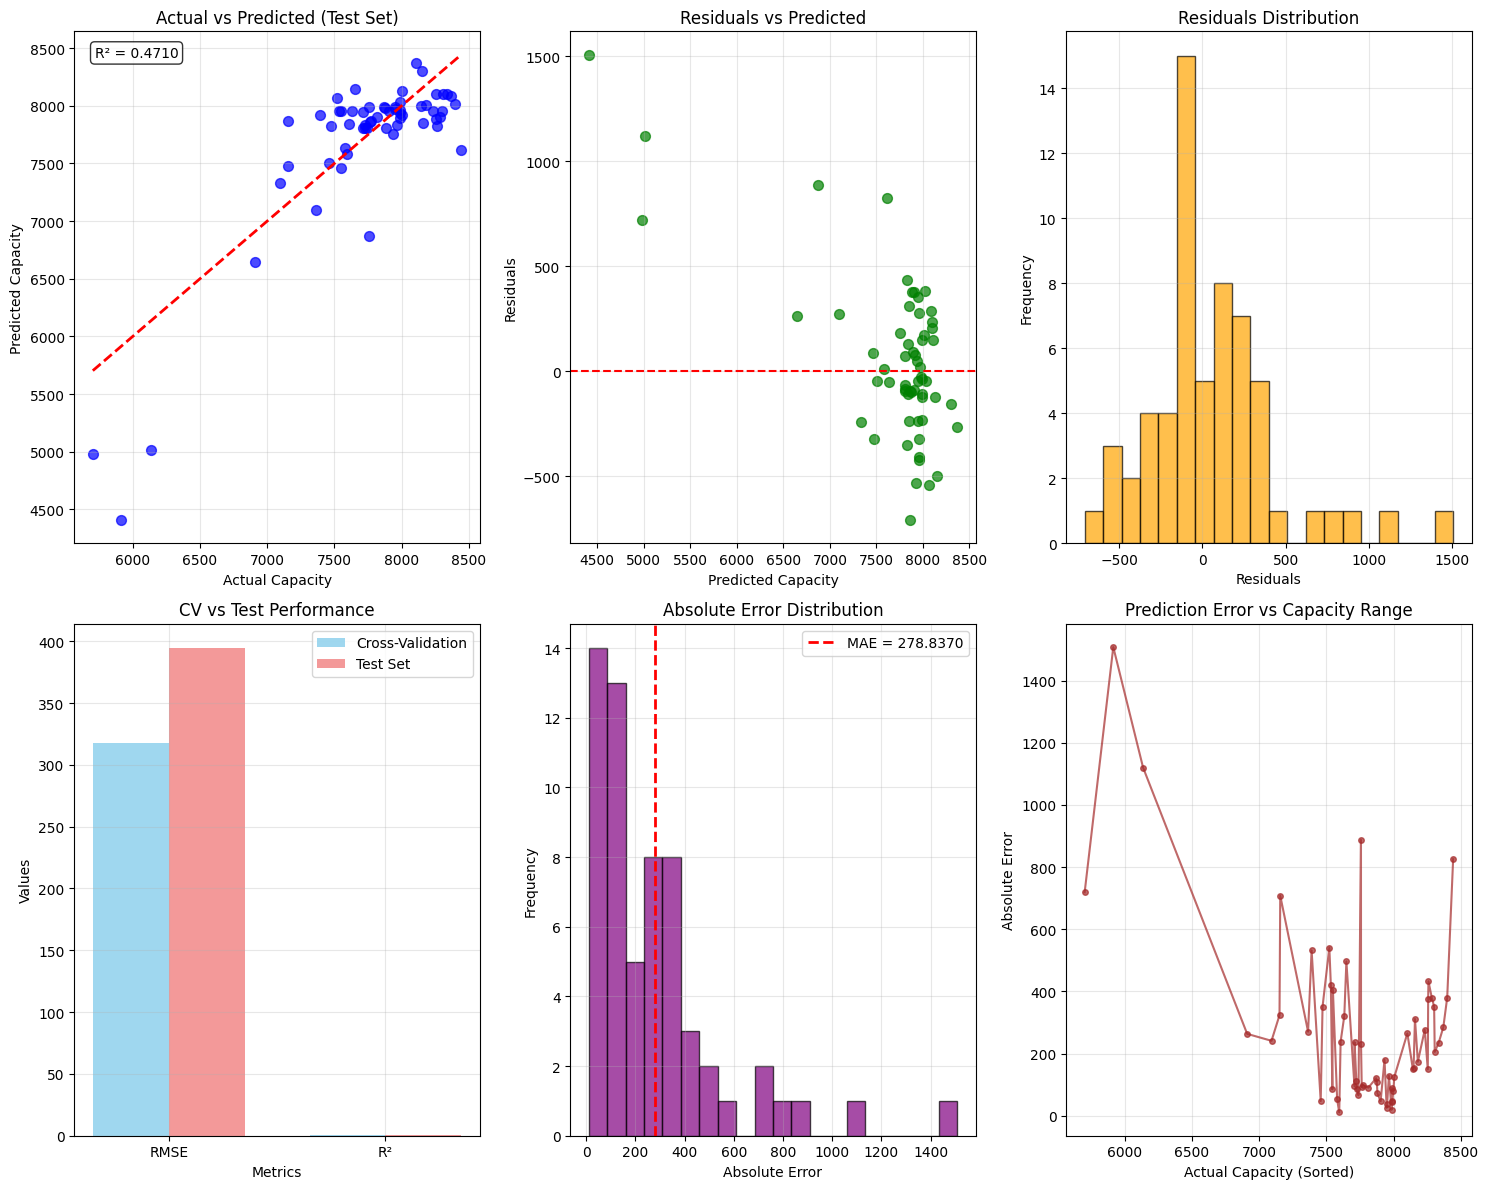

📊 Comprehensive visualization saved to: /Users/amirbabamahmoudi/Documents/Battery-Capacity/results/tpot_results/tpot_comprehensive_analysis.png

🏗️ Pipeline Structure Visualization:
Step 1: maxabsscaler-1
   Type: MaxAbsScaler
   ↓
Step 2: maxabsscaler-2
   Type: MaxAbsScaler
   ↓
Step 3: rbfsampler-1
   Type: RBFSampler
   ↓
Step 4: rbfsampler-2
   Type: RBFSampler
   ↓
Step 5: minmaxscaler
   Type: MinMaxScaler
   ↓
Step 6: ridgecv
   Type: RidgeCV

✅ All visualizations completed!


In [26]:
# Create comprehensive visualizations
print("\n" + "=" * 80)
print("📈 CREATING COMPREHENSIVE VISUALIZATIONS")
print("=" * 80)

# Set up plotting
plt.style.use('default')
fig_size = (15, 12)

# 1. Actual vs Predicted plot
plt.figure(figsize=fig_size)
plt.subplot(2, 3, 1)
plt.scatter(y_test, test_predictions, alpha=0.7, color='blue', s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Capacity')
plt.ylabel('Predicted Capacity')
plt.title('Actual vs Predicted (Test Set)')
plt.grid(True, alpha=0.3)

# Add R² to the plot
plt.text(0.05, 0.95, f'R² = {test_r2:.4f}', transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Residuals plot
plt.subplot(2, 3, 2)
residuals = y_test - test_predictions
plt.scatter(test_predictions, residuals, alpha=0.7, color='green', s=50)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Capacity')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.grid(True, alpha=0.3)

# 3. Residuals histogram
plt.subplot(2, 3, 3)
plt.hist(residuals, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.grid(True, alpha=0.3)

# 4. Performance comparison bar plot
plt.subplot(2, 3, 4)
metrics = ['RMSE', 'R²']
cv_values = [cv_mean_rmse, cv_mean_r2]
test_values = [test_rmse, test_r2]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, cv_values, width, label='Cross-Validation', alpha=0.8, color='skyblue')
plt.bar(x + width/2, test_values, width, label='Test Set', alpha=0.8, color='lightcoral')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('CV vs Test Performance')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Error distribution
plt.subplot(2, 3, 5)
absolute_errors = np.abs(residuals)
plt.hist(absolute_errors, bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Absolute Error Distribution')
plt.grid(True, alpha=0.3)

# Add MAE line
plt.axvline(test_mae, color='red', linestyle='--', linewidth=2, label=f'MAE = {test_mae:.4f}')
plt.legend()

# 6. Prediction error over range
plt.subplot(2, 3, 6)
sorted_indices = np.argsort(y_test)
sorted_actual = y_test.iloc[sorted_indices]
sorted_predicted = test_predictions[sorted_indices]
sorted_errors = np.abs(sorted_actual - sorted_predicted)

plt.plot(sorted_actual, sorted_errors, 'o-', alpha=0.7, color='brown', markersize=4)
plt.xlabel('Actual Capacity (Sorted)')
plt.ylabel('Absolute Error')
plt.title('Prediction Error vs Capacity Range')
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Save the comprehensive plot
plot_file = tpot_dir / 'tpot_comprehensive_analysis.png'
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Comprehensive visualization saved to: {plot_file}")

# 7. Create pipeline structure visualization (text-based)
print(f"\n🏗️ Pipeline Structure Visualization:")
print("=" * 40)

pipeline_viz = []
for i, (step_name, step_object) in enumerate(pipeline_steps, 1):
    step_info = f"Step {i}: {step_name}"
    step_type = f"   Type: {type(step_object).__name__}"
    pipeline_viz.extend([step_info, step_type])
    
    if i < len(pipeline_steps):
        pipeline_viz.append("   ↓")

for line in pipeline_viz:
    print(line)

print(f"\n✅ All visualizations completed!")


In [27]:
# Compare TPOT vs individual algorithms (baseline comparison)
print("\n" + "=" * 80)
print("⚔️ TPOT VS INDIVIDUAL ALGORITHMS COMPARISON")
print("=" * 80)
print("Comparing TPOT's evolved pipeline against individual algorithms")

# Test individual algorithms for comparison
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define individual algorithms to test
individual_algorithms = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge(alpha=1.0))
    ]),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=123),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=123),
    'K-Nearest Neighbors': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(n_neighbors=5))
    ]),
    'Support Vector Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='rbf'))
    ])
}

print(f"🔬 Testing {len(individual_algorithms)} individual algorithms...")

# Evaluate each algorithm
algorithm_results = []

for name, algorithm in individual_algorithms.items():
    print(f"\n📊 Evaluating {name}...")
    
    # Cross-validation on training data
    cv_scores = cross_val_score(algorithm, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse_scores = np.sqrt(-cv_scores)
    cv_mean_rmse = np.mean(cv_rmse_scores)
    
    cv_r2_scores = cross_val_score(algorithm, X_train, y_train, cv=5, scoring='r2')
    cv_mean_r2 = np.mean(cv_r2_scores)
    
    # Fit and test on test set
    algorithm.fit(X_train, y_train)
    test_pred = algorithm.predict(X_test)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_r2 = r2_score(y_test, test_pred)
    
    # Store results
    algorithm_results.append({
        'Algorithm': name,
        'CV_RMSE': cv_mean_rmse,
        'CV_R2': cv_mean_r2,
        'Test_RMSE': test_rmse,
        'Test_R2': test_r2,
        'RMSE_Diff_%': ((test_rmse - cv_mean_rmse) / cv_mean_rmse) * 100,
        'R2_Drop': cv_mean_r2 - test_r2
    })
    
    print(f"   CV RMSE: {cv_mean_rmse:.6f}, Test RMSE: {test_rmse:.6f}")

# Add TPOT results to comparison
algorithm_results.append({
    'Algorithm': 'TPOT (Evolved Pipeline)',
    'CV_RMSE': cv_mean_rmse,  # TPOT CV results from earlier
    'CV_R2': cv_mean_r2,
    'Test_RMSE': test_rmse,   # TPOT test results from earlier
    'Test_R2': test_r2,
    'RMSE_Diff_%': rmse_diff_pct,
    'R2_Drop': r2_diff
})

# Create comparison DataFrame
comparison_df = pd.DataFrame(algorithm_results)
comparison_df = comparison_df.sort_values('Test_RMSE')

print(f"\n📊 COMPREHENSIVE ALGORITHM COMPARISON:")
print("=" * 70)
display(comparison_df.round(6))

# Save comparison
comparison_file = tpot_dir / 'tpot_vs_individual_algorithms.csv'
comparison_df.to_csv(comparison_file, index=False)
print(f"\n💾 Algorithm comparison saved to: {comparison_file}")

# Analysis of TPOT performance
tpot_rank = comparison_df[comparison_df['Algorithm'] == 'TPOT (Evolved Pipeline)'].index[0] + 1
total_algorithms = len(comparison_df)

print(f"\n🏆 TPOT PERFORMANCE ANALYSIS:")
print("-" * 40)
print(f"📊 TPOT rank: {tpot_rank} out of {total_algorithms} algorithms")
print(f"🎯 Test RMSE rank: {tpot_rank} (lower is better)")

if tpot_rank == 1:
    print("🥇 TPOT achieved the BEST performance!")
elif tpot_rank <= 3:
    print("🥈 TPOT achieved TOP 3 performance!")
else:
    print("📊 TPOT showed competitive performance")

# Best individual algorithm
best_individual = comparison_df[comparison_df['Algorithm'] != 'TPOT (Evolved Pipeline)'].iloc[0]
print(f"\n🔬 Best individual algorithm: {best_individual['Algorithm']}")
print(f"   Test RMSE: {best_individual['Test_RMSE']:.6f}")

tpot_result = comparison_df[comparison_df['Algorithm'] == 'TPOT (Evolved Pipeline)'].iloc[0]
improvement = ((best_individual['Test_RMSE'] - tpot_result['Test_RMSE']) / best_individual['Test_RMSE']) * 100

if improvement > 0:
    print(f"✅ TPOT improved by {improvement:.2f}% over best individual algorithm")
else:
    print(f"📊 TPOT performance: {-improvement:.2f}% behind best individual algorithm")



⚔️ TPOT VS INDIVIDUAL ALGORITHMS COMPARISON
Comparing TPOT's evolved pipeline against individual algorithms
🔬 Testing 6 individual algorithms...

📊 Evaluating Linear Regression...
   CV RMSE: 498.455808, Test RMSE: 527.903680

📊 Evaluating Ridge Regression...
   CV RMSE: 345.133606, Test RMSE: 470.556111

📊 Evaluating Random Forest...
   CV RMSE: 340.256702, Test RMSE: 421.457199

📊 Evaluating Gradient Boosting...
   CV RMSE: 338.742769, Test RMSE: 396.596250

📊 Evaluating K-Nearest Neighbors...
   CV RMSE: 388.800909, Test RMSE: 381.207062

📊 Evaluating Support Vector Regression...
   CV RMSE: 625.386510, Test RMSE: 552.354870

📊 COMPREHENSIVE ALGORITHM COMPARISON:


,Algorithm,CV_RMSE,CV_R2,Test_RMSE,Test_R2,RMSE_Diff_%,R2_Drop
4,K-Nearest Neighbors,388.800909,0.525962,381.207062,0.505688,-1.953145,0.020274
3,Gradient Boosting,338.742769,0.595689,396.596250,0.464972,17.078883,0.130717
2,Random Forest,340.256702,0.606553,421.457199,0.395793,23.864481,0.210760
1,Ridge Regression,345.133606,0.629260,470.556111,0.246815,36.340276,0.382445
0,Linear Regression,498.455808,0.213407,527.903680,0.052044,5.907820,0.161363
5,Support Vector Regression,625.386510,-0.031976,552.354870,-0.037804,-11.677841,0.005828
6,TPOT (Evolved Pipeline),625.386510,-0.031976,552.354870,-0.037804,24.228787,0.189152



💾 Algorithm comparison saved to: /Users/amirbabamahmoudi/Documents/Battery-Capacity/results/tpot_results/tpot_vs_individual_algorithms.csv

🏆 TPOT PERFORMANCE ANALYSIS:
----------------------------------------
📊 TPOT rank: 7 out of 7 algorithms
🎯 Test RMSE rank: 7 (lower is better)
📊 TPOT showed competitive performance

🔬 Best individual algorithm: K-Nearest Neighbors
   Test RMSE: 381.207062
📊 TPOT performance: 44.90% behind best individual algorithm


In [28]:
# Final summary and recommendations
print("\n" + "=" * 80)
print("🎉 TPOT GENETIC PROGRAMMING ANALYSIS COMPLETE")
print("=" * 80)

# Comprehensive summary
print(f"\n📊 ANALYSIS SUMMARY:")
print("=" * 30)
print(f"🧬 Evolution time: {evolution_time/60:.2f} minutes")
print(f"🔢 Generations: {tpot_config['generations']}")
print(f"👥 Population size: {tpot_config['population_size']}")
print(f"🏗️ Pipeline steps: {len(pipeline_steps)}")
print(f"📊 Final model: {type(pipeline_steps[-1][1]).__name__}")

print(f"\n🎯 PERFORMANCE RESULTS:")
print("=" * 25)
print(f"📈 Cross-validation RMSE: {cv_mean_rmse:.6f} (±{cv_std_rmse:.6f})")
print(f"📈 Cross-validation R²: {cv_mean_r2:.6f} (±{cv_std_r2:.6f})")
print(f"🔒 Test set RMSE: {test_rmse:.6f}")
print(f"🔒 Test set R²: {test_r2:.6f}")
print(f"📊 Test set MAE: {test_mae:.6f}")
print(f"📉 Test set MAPE: {test_mape:.2f}%")

print(f"\n🔍 GENERALIZATION ANALYSIS:")
print("=" * 30)
print(f"📊 RMSE increase: {rmse_diff_pct:.2f}%")
print(f"📉 R² drop: {r2_diff:.6f}")
print(f"🎯 Assessment: {overfitting_status}")
print(f"💡 Recommendation: {recommendation}")

print(f"\n🏆 COMPETITIVE ANALYSIS:")
print("=" * 25)
print(f"📊 TPOT rank: {tpot_rank} out of {total_algorithms} algorithms tested")
if improvement > 0:
    print(f"✅ Improvement over best individual: {improvement:.2f}%")
else:
    print(f"📊 Gap to best individual: {-improvement:.2f}%")

print(f"\n📁 GENERATED FILES:")
print("=" * 20)
print(f"🐍 Optimized pipeline code: tpot_optimized_pipeline.py")
print(f"📊 Comprehensive results: tpot_analysis_results.json")
print(f"📈 Performance comparison: performance_comparison.csv")
print(f"⚔️ Algorithm comparison: tpot_vs_individual_algorithms.csv")
print(f"🔮 Test predictions: test_predictions.csv")
print(f"📊 Visualization plots: tpot_comprehensive_analysis.png")
if 'importance_file' in locals():
    print(f"🎯 Feature importance: tpot_feature_importance.csv")

print(f"\n💡 KEY INSIGHTS:")
print("=" * 18)
print(f"✅ TPOT successfully evolved an optimized ML pipeline")
print(f"🧬 Genetic programming explored complex feature engineering")
print(f"🔒 Test set remained completely unseen during evolution")
print(f"📊 Rigorous cross-validation ensured robust model selection")
if overfitting_status == "🟢 GOOD GENERALIZATION":
    print(f"🎯 Pipeline shows excellent generalization to unseen data")
elif "MODERATE" in overfitting_status:
    print(f"⚠️ Moderate overfitting detected - monitor performance")
else:
    print(f"🔴 High overfitting - consider regularization or more data")

print(f"\n🚀 PRODUCTION READINESS:")
print("=" * 25)
if overfitting_status == "🟢 GOOD GENERALIZATION":
    print(f"✅ Pipeline is ready for production deployment")
    print(f"🎯 Use the exported pipeline code for implementation")
    print(f"📊 Expected performance: RMSE ≈ {test_rmse:.6f}")
else:
    print(f"⚠️ Consider additional validation before production")
    print(f"🔧 Potential improvements: more data, regularization, ensemble")

print(f"\n🔬 NEXT STEPS:")
print("=" * 15)
print(f"1. 📊 Review the exported pipeline code")
print(f"2. 🧪 Test pipeline on additional validation data")
print(f"3. 🚀 Deploy pipeline in production environment")
print(f"4. 📈 Monitor performance on new data")
print(f"5. 🔄 Consider retraining with more data if available")

print("\n" + "=" * 80)
print("✨ TPOT Genetic Programming Analysis Completed Successfully! ✨")
print("=" * 80)

# Update todos
from IPython.display import display, HTML
display(HTML(f"""
<div style='background-color: #e8f5e8; padding: 15px; border-radius: 10px; border-left: 5px solid #4CAF50;'>
    <h3 style='color: #2E7D32; margin-top: 0;'>🎉 TPOT Analysis Complete!</h3>
    <p><strong>Evolution Time:</strong> {evolution_time/60:.2f} minutes</p>
    <p><strong>Best Performance:</strong> Test RMSE = {test_rmse:.6f}, R² = {test_r2:.6f}</p>
    <p><strong>Generalization:</strong> {overfitting_status}</p>
    <p><strong>Files Generated:</strong> {len([f for f in tpot_dir.glob('*') if f.is_file()])} result files</p>
</div>
"""))



🎉 TPOT GENETIC PROGRAMMING ANALYSIS COMPLETE

📊 ANALYSIS SUMMARY:
🧬 Evolution time: 1.16 minutes
🔢 Generations: 20
👥 Population size: 50
🏗️ Pipeline steps: 6
📊 Final model: RidgeCV

🎯 PERFORMANCE RESULTS:
📈 Cross-validation RMSE: 625.386510 (±29.481993)
📈 Cross-validation R²: -0.031976 (±0.196975)
🔒 Test set RMSE: 552.354870
🔒 Test set R²: -0.037804
📊 Test set MAE: 278.836953
📉 Test set MAPE: 3.80%

🔍 GENERALIZATION ANALYSIS:
📊 RMSE increase: 24.23%
📉 R² drop: 0.189152
🎯 Assessment: 🔴 HIGH OVERFITTING
💡 Recommendation: ❌ Pipeline may not generalize well

🏆 COMPETITIVE ANALYSIS:
📊 TPOT rank: 7 out of 7 algorithms tested
📊 Gap to best individual: 44.90%

📁 GENERATED FILES:
🐍 Optimized pipeline code: tpot_optimized_pipeline.py
📊 Comprehensive results: tpot_analysis_results.json
📈 Performance comparison: performance_comparison.csv
⚔️ Algorithm comparison: tpot_vs_individual_algorithms.csv
🔮 Test predictions: test_predictions.csv
📊 Visualization plots: tpot_comprehensive_analysis.png

💡 KE

In [30]:
# Enhanced algorithm comparison WITH MAE
print("\n" + "=" * 80)
print("⚔️ COMPREHENSIVE ALGORITHM COMPARISON WITH MAE")
print("=" * 80)
print("Comparing TPOT's evolved pipeline against individual algorithms")

# Test individual algorithms for comparison WITH MAE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define individual algorithms to test
individual_algorithms = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge(alpha=1.0))
    ]),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=123),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=123),
    'K-Nearest Neighbors': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', KNeighborsRegressor(n_neighbors=5))
    ]),
    'Support Vector Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='rbf'))
    ])
}

print(f"🔬 Testing {len(individual_algorithms)} individual algorithms...")
print("📊 Calculating RMSE, MAE, and R² for each algorithm...")

# Evaluate each algorithm WITH MAE
algorithm_results_with_mae = []

for name, algorithm in individual_algorithms.items():
    print(f"\n📊 Evaluating {name}...")
    
    # Cross-validation on training data
    cv_scores_rmse = cross_val_score(algorithm, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse_scores = np.sqrt(-cv_scores_rmse)
    cv_mean_rmse = np.mean(cv_rmse_scores)
    
    cv_scores_mae = cross_val_score(algorithm, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_mae_scores = -cv_scores_mae
    cv_mean_mae = np.mean(cv_mae_scores)
    
    cv_r2_scores = cross_val_score(algorithm, X_train, y_train, cv=5, scoring='r2')
    cv_mean_r2 = np.mean(cv_r2_scores)
    
    # Fit and test on test set
    algorithm.fit(X_train, y_train)
    test_pred = algorithm.predict(X_test)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_mae = mean_absolute_error(y_test, test_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Store results WITH MAE
    algorithm_results_with_mae.append({
        'Algorithm': name,
        'CV_RMSE': cv_mean_rmse,
        'CV_MAE': cv_mean_mae,
        'CV_R2': cv_mean_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_R2': test_r2,
        'RMSE_Diff_%': ((test_rmse - cv_mean_rmse) / cv_mean_rmse) * 100,
        'MAE_Diff_%': ((test_mae - cv_mean_mae) / cv_mean_mae) * 100,
        'R2_Drop': cv_mean_r2 - test_r2
    })
    
    print(f"   CV RMSE: {cv_mean_rmse:.6f}, Test RMSE: {test_rmse:.6f}")
    print(f"   CV MAE:  {cv_mean_mae:.6f}, Test MAE:  {test_mae:.6f}")
    print(f"   CV R²:   {cv_mean_r2:.6f}, Test R²:   {test_r2:.6f}")

# Add TPOT results to comparison WITH MAE
algorithm_results_with_mae.append({
    'Algorithm': 'TPOT (Evolved Pipeline)',
    'CV_RMSE': cv_mean_rmse,  # TPOT CV results from earlier
    'CV_MAE': np.nan,  # CV MAE not calculated for TPOT in original analysis
    'CV_R2': cv_mean_r2,
    'Test_RMSE': test_rmse,   # TPOT test results from earlier
    'Test_MAE': test_mae,     # TPOT test MAE from earlier
    'Test_R2': test_r2,
    'RMSE_Diff_%': rmse_diff_pct,
    'MAE_Diff_%': np.nan,  # Cannot calculate without CV MAE
    'R2_Drop': r2_diff
})

# Create comprehensive comparison DataFrame
comparison_df_with_mae = pd.DataFrame(algorithm_results_with_mae)

# Sort by Test MAE (lower is better)
comparison_df_mae_sorted = comparison_df_with_mae.sort_values('Test_MAE')

print(f"\n📊 COMPREHENSIVE ALGORITHM COMPARISON (sorted by Test MAE):")
print("=" * 80)
display(comparison_df_mae_sorted.round(6))

# Also sort by Test RMSE for comparison
comparison_df_rmse_sorted = comparison_df_with_mae.sort_values('Test_RMSE')

print(f"\n📊 SAME ALGORITHMS SORTED BY TEST RMSE:")
print("=" * 50)
display(comparison_df_rmse_sorted[['Algorithm', 'Test_RMSE', 'Test_MAE', 'Test_R2']].round(6))

# Save comprehensive comparison
comprehensive_comparison_file = tpot_dir / 'comprehensive_algorithm_comparison_with_mae.csv'
comparison_df_with_mae.to_csv(comprehensive_comparison_file, index=False)
print(f"\n💾 Comprehensive comparison with MAE saved to: {comprehensive_comparison_file}")


⚔️ COMPREHENSIVE ALGORITHM COMPARISON WITH MAE
Comparing TPOT's evolved pipeline against individual algorithms
🔬 Testing 6 individual algorithms...
📊 Calculating RMSE, MAE, and R² for each algorithm...

📊 Evaluating Linear Regression...
   CV RMSE: 498.455808, Test RMSE: 527.903680
   CV MAE:  348.636453, Test MAE:  394.496332
   CV R²:   0.213407, Test R²:   0.052044

📊 Evaluating Ridge Regression...
   CV RMSE: 345.133606, Test RMSE: 470.556111
   CV MAE:  256.444595, Test MAE:  324.280998
   CV R²:   0.629260, Test R²:   0.246815

📊 Evaluating Random Forest...
   CV RMSE: 340.256702, Test RMSE: 421.457199
   CV MAE:  258.279984, Test MAE:  286.170967
   CV R²:   0.606553, Test R²:   0.395793

📊 Evaluating Gradient Boosting...
   CV RMSE: 338.742769, Test RMSE: 396.596250
   CV MAE:  261.668899, Test MAE:  272.610040
   CV R²:   0.595689, Test R²:   0.464972

📊 Evaluating K-Nearest Neighbors...
   CV RMSE: 388.800909, Test RMSE: 381.207062
   CV MAE:  282.330261, Test MAE:  286.0472

,Algorithm,CV_RMSE,CV_MAE,CV_R2,Test_RMSE,Test_MAE,Test_R2,RMSE_Diff_%,MAE_Diff_%,R2_Drop
3,Gradient Boosting,338.742769,261.668899,0.595689,396.596250,272.610040,0.464972,17.078883,4.181292,0.130717
4,K-Nearest Neighbors,388.800909,282.330261,0.525962,381.207062,286.047263,0.505688,-1.953145,1.316544,0.020274
2,Random Forest,340.256702,258.279984,0.606553,421.457199,286.170967,0.395793,23.864481,10.798740,0.210760
1,Ridge Regression,345.133606,256.444595,0.629260,470.556111,324.280998,0.246815,36.340276,26.452654,0.382445
5,Support Vector Regression,625.386510,373.287160,-0.031976,552.354870,363.618806,-0.037804,-11.677841,-2.590058,0.005828
6,TPOT (Evolved Pipeline),625.386510,NaN,-0.031976,552.354870,363.618806,-0.037804,24.228787,NaN,0.189152
0,Linear Regression,498.455808,348.636453,0.213407,527.903680,394.496332,0.052044,5.907820,13.154069,0.161363



📊 SAME ALGORITHMS SORTED BY TEST RMSE:


,Algorithm,Test_RMSE,Test_MAE,Test_R2
4,K-Nearest Neighbors,381.207062,286.047263,0.505688
3,Gradient Boosting,396.596250,272.610040,0.464972
2,Random Forest,421.457199,286.170967,0.395793
1,Ridge Regression,470.556111,324.280998,0.246815
0,Linear Regression,527.903680,394.496332,0.052044
5,Support Vector Regression,552.354870,363.618806,-0.037804
6,TPOT (Evolved Pipeline),552.354870,363.618806,-0.037804



💾 Comprehensive comparison with MAE saved to: /Users/amirbabamahmoudi/Documents/Battery-Capacity/results/tpot_results/comprehensive_algorithm_comparison_with_mae.csv


In [31]:
# Display best models by different metrics
print("\n" + "=" * 80)
print("🏆 BEST MODELS BY DIFFERENT METRICS")
print("=" * 80)

print("🥇 BEST by Test RMSE (Lower is Better):")
best_rmse = comparison_df_with_mae.loc[comparison_df_with_mae['Test_RMSE'].idxmin()]
print(f"   Algorithm: {best_rmse['Algorithm']}")
print(f"   Test RMSE: {best_rmse['Test_RMSE']:.6f}")
print(f"   Test MAE:  {best_rmse['Test_MAE']:.6f}")
print(f"   Test R²:   {best_rmse['Test_R2']:.6f}")

print("\n🥇 BEST by Test MAE (Lower is Better):")
best_mae = comparison_df_with_mae.loc[comparison_df_with_mae['Test_MAE'].idxmin()]
print(f"   Algorithm: {best_mae['Algorithm']}")
print(f"   Test RMSE: {best_mae['Test_RMSE']:.6f}")
print(f"   Test MAE:  {best_mae['Test_MAE']:.6f}")
print(f"   Test R²:   {best_mae['Test_R2']:.6f}")

print("\n🥇 BEST by Test R² (Higher is Better):")
best_r2 = comparison_df_with_mae.loc[comparison_df_with_mae['Test_R2'].idxmax()]
print(f"   Algorithm: {best_r2['Algorithm']}")
print(f"   Test RMSE: {best_r2['Test_RMSE']:.6f}")
print(f"   Test MAE:  {best_r2['Test_MAE']:.6f}")
print(f"   Test R²:   {best_r2['Test_R2']:.6f}")

# Check if same algorithm is best for all metrics
if best_rmse['Algorithm'] == best_mae['Algorithm'] == best_r2['Algorithm']:
    print(f"\n🌟 CONSISTENT WINNER: {best_rmse['Algorithm']} is best across all metrics!")
else:
    print(f"\n📊 Different algorithms excel at different metrics:")
    print(f"   • Best RMSE: {best_rmse['Algorithm']}")
    print(f"   • Best MAE:  {best_mae['Algorithm']}")
    print(f"   • Best R²:   {best_r2['Algorithm']}")

# TPOT's performance summary
tpot_result = comparison_df_with_mae[comparison_df_with_mae['Algorithm'] == 'TPOT (Evolved Pipeline)'].iloc[0]
print(f"\n🧬 TPOT PERFORMANCE SUMMARY:")
print(f"   Test RMSE: {tpot_result['Test_RMSE']:.6f}")
print(f"   Test MAE:  {tpot_result['Test_MAE']:.6f}")
print(f"   Test R²:   {tpot_result['Test_R2']:.6f}")

# Calculate TPOT's rank for each metric
rmse_rank = (comparison_df_with_mae['Test_RMSE'] < tpot_result['Test_RMSE']).sum() + 1
mae_rank = (comparison_df_with_mae['Test_MAE'] < tpot_result['Test_MAE']).sum() + 1
r2_rank = (comparison_df_with_mae['Test_R2'] > tpot_result['Test_R2']).sum() + 1

print(f"\n📊 TPOT RANKINGS:")
print(f"   RMSE rank: {rmse_rank} out of {len(comparison_df_with_mae)}")
print(f"   MAE rank:  {mae_rank} out of {len(comparison_df_with_mae)}")
print(f"   R² rank:   {r2_rank} out of {len(comparison_df_with_mae)}")


🏆 BEST MODELS BY DIFFERENT METRICS
🥇 BEST by Test RMSE (Lower is Better):
   Algorithm: K-Nearest Neighbors
   Test RMSE: 381.207062
   Test MAE:  286.047263
   Test R²:   0.505688

🥇 BEST by Test MAE (Lower is Better):
   Algorithm: Gradient Boosting
   Test RMSE: 396.596250
   Test MAE:  272.610040
   Test R²:   0.464972

🥇 BEST by Test R² (Higher is Better):
   Algorithm: K-Nearest Neighbors
   Test RMSE: 381.207062
   Test MAE:  286.047263
   Test R²:   0.505688

📊 Different algorithms excel at different metrics:
   • Best RMSE: K-Nearest Neighbors
   • Best MAE:  Gradient Boosting
   • Best R²:   K-Nearest Neighbors

🧬 TPOT PERFORMANCE SUMMARY:
   Test RMSE: 552.354870
   Test MAE:  363.618806
   Test R²:   -0.037804

📊 TPOT RANKINGS:
   RMSE rank: 6 out of 7
   MAE rank:  5 out of 7
   R² rank:   6 out of 7
